# Motivation

- this tutorial is also available as a [colab notebook](https://colab.research.google.com/drive/1SJtGSP_1XcjLh0pyF_RwmakUMdDuNcxt?usp=sharing)

Continuing with the Vandermonde interpolation example this tutorial goes step by step on how computers typically implement matrix inversions for the purpose of solving least squares problems.

This typically takes the form of a matrix factorization of the matrix to be inverted followed by forward and back substitution. The matrix factorization demoed here is LU decomposition. We compare our hand-coded solvers with Numpy library solvers to compare results.

In [0]:
cd 'drive/My Drive/Colab Notebooks/Solving Least Squares Problems'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Solving Least Squares Problems'
/content


# Mechanics of solving a least squares problem
## Introduction to LU decomposition 

Our goal is to explore how to solve systems of linear equations following Trefethan and fastai's numerical linear algebrea course: https://www.youtube.com/watch?v=O2x5KPJr5ag&list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY&index=5.

# First perform LU decomposition
https://en.wikipedia.org/wiki/LU_decomposition

It is also based on Trefethen ch. 20 on LU decompositions and ch. 17 on Backsubstitution.
https://www.amazon.com/Numerical-Linear-Algebra-Lloyd-Trefethen/dp/0898713617

LU decomposition is essentially Gaussian elimination to find the upper matrix while recording your operations in the lower matrix

In [0]:
import numpy as np
def LU(A):
    U = np.copy(A)
    m, n = A.shape
    L = np.eye(n)
    for k in range(n-1):
        for j in range(k+1,n):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:n] -= L[j,k] * U[k,k:n]
    return L, U

In [0]:
A = np.array([[1,2,-3],[2,-1,1],[1,4,-2]]).astype(np.float)
print(A)

[[ 1.  2. -3.]
 [ 2. -1.  1.]
 [ 1.  4. -2.]]
[[ 1.  2. -3.]
 [ 2. -1.  1.]
 [ 1.  4. -2.]]


In [0]:
L, U = LU(A)
print("L = ")
print(L)
print("U = ")
print(U)

L = 
[[ 1.   0.   0. ]
 [ 2.   1.   0. ]
 [ 1.  -0.4  1. ]]
U = 
[[ 1.   2.  -3. ]
 [ 0.  -5.   7. ]
 [ 0.   0.   3.8]]
L = 
[[ 1.   0.   0. ]
 [ 2.   1.   0. ]
 [ 1.  -0.4  1. ]]
U = 
[[ 1.   2.  -3. ]
 [ 0.  -5.   7. ]
 [ 0.   0.   3.8]]


In [0]:
print("LU = ")
print(L@U)

LU = 
[[ 1.  2. -3.]
 [ 2. -1.  1.]
 [ 1.  4. -2.]]
LU = 
[[ 1.  2. -3.]
 [ 2. -1.  1.]
 [ 1.  4. -2.]]


In [0]:
b = np.array([[1],[1],[9]])
print(b)

[[1]
 [1]
 [9]]
[[1]
 [1]
 [9]]


Here L and U must be square. Once we have our matrix factorizations of $A$, then we can solve for $x$ in a 2 step process:

1. solve for $y$ in $Ly = b$
2. then solve for $x$ after solving for $y$ in $Ux = y$

In [0]:
def forwardsub(L, b):
    y = np.zeros(len(L))
    y[0] = b[0]
    for i in range(1,len(y)):
        y[i] = b[i] - np.dot(L[i,:],y)
    return y

In [0]:
def backsub(U, y):
    N = len(U)
    x = np.zeros([N,1])
    x[-1] = y[-1]/U[-1,-1] 
    for i in range(N-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,:],x))/float(U[i,i])
    return x

In [0]:
y = forwardsub(L, b)
x = backsub(U, y)
print(x)

[[1.]
 [3.]
 [2.]]
[[1.]
 [3.]
 [2.]]


In [0]:
bhat = (A@x)

In [0]:
np.allclose(b,bhat)

True

True

Yay we got back the same solution!
 ## Put into function and compare against Numpy
We can combine all 3 of these functions in a least squares solver..

In [0]:
def LU_solve(A, b):
    L, U = LU(A)
    y = forwardsub(L, b)
    x = backsub(U, y)
    return x

In [0]:
x = LU_solve(A, b)
print(x)

[[1.]
 [3.]
 [2.]]
[[1.]
 [3.]
 [2.]]


In [0]:
A@x

array([[1.],
       [1.],
       [9.]])

array([[1.],
       [1.],
       [9.]])

Finally let's check against numpy's built in least squares solver...

In [0]:
print(np.linalg.lstsq(A, b, rcond = None)[0])

[[1.]
 [3.]
 [2.]]
[[1.]
 [3.]
 [2.]]


Yay we get the same answer as numpy's least squares solver!

# Now let's applied what we've learned to an interpolation example 

Our goal is to interpolate the function below

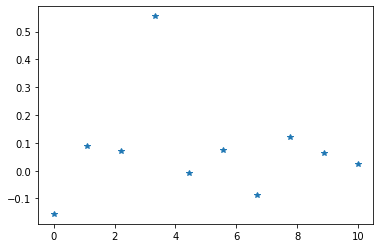

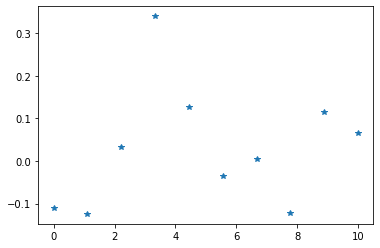

In [0]:
import matplotlib.pyplot as plt
nSamples = 10
t = np.linspace(0, 10, nSamples)
y = np.exp(-5*(t-3)**2)+0.1*np.random.randn(nSamples)

plt.plot(t,y,'*')
plt.show()

In [0]:
deg=6
A = np.vander(y, N=deg, increasing=True)

Here we solve the interpolation problem by solving for $x$ in the given equation $y = Ax$, found by taking the pseudo inverse:

\begin{equation}
(A^*A)^{-1}A^*y = x
\end{equation}

This works by left multiply $y=Ax$ by $A^*$ to get $A^*y = A^*Ax$ and then noticing that $A^*A$ is a square matrix, which thus can be inverted using the LU decomposition solve we introduced above

(If $[A] = [m \times n]$ then $[A*A] = [n \times m] \times [m \times n] = [n \times n]$)

Above is how things work mathematically, to actually do this in code we need to look at the problem like this...

Our goal is to estimate $y$ by using the Vandermonde matrix and an appropriate $x$ vector such that 

\begin{equation}
y \approx \hat{y} = Ax
\end{equation}

however to find the appropriate $x$ we must perform least squares fitting....

\begin{equation}
x = \min ||y-\hat{y}||_2^2 = \min || y - Ax ||_2^2
\end{equation}

Anyway to solve equation 1 we actually back up a step before finding the inverse

\begin{equation}
A^*y = A^*A x
\end{equation}

which we can rewrite as $Y = A^*y$ and $A^*A = M$ to get 

\begin{equation}
Mx = Y
\end{equation}

and invert to find x exactly like we did above

In [0]:
Astar = np.conjugate(A.transpose())
print(np.shape(Astar))

(6, 10)
(6, 10)


In [0]:
print(np.shape(Astar@A))

(6, 6)
(6, 6)


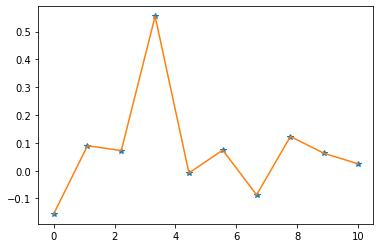

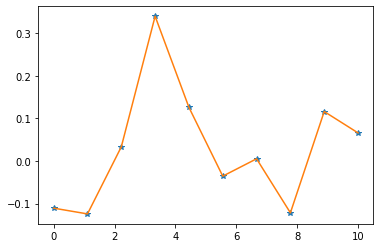

In [0]:
x = LU_solve(Astar@A, Astar@y)
plt.plot(t,y,'*',t,A@x)
plt.show()

# Compare results
Finally we put it all into a function a show that this is a solution for Least squares of *rectangular* matrices

In [0]:
def LUsolveRect(A, y):
    Astar = np.conjugate(A.transpose())
    x = LU_solve(Astar@A, Astar@y)
    return x

In [0]:
x = LUsolveRect(A, y)
print(x)

[[ 6.49036380e-14]
 [ 1.00000000e+00]
 [-2.24586093e-11]
 [ 1.26177226e-10]
 [ 1.10151372e-09]
 [-2.25442647e-09]]
[[ 4.70179451e-15]
 [ 1.00000000e+00]
 [-3.83457512e-12]
 [ 1.17952022e-11]
 [ 2.43384392e-10]
 [-7.20062159e-10]]


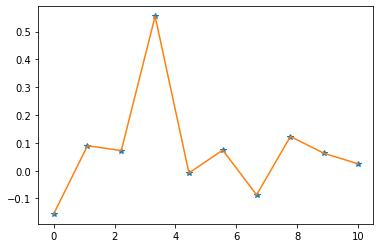

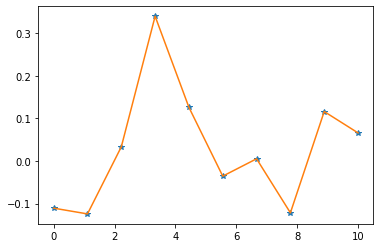

In [0]:
plt.plot(t,y,'*',t,A@x)
plt.show()

In [0]:
x = np.linalg.lstsq(A, y, rcond=None)[0]
print(x)

[ 4.30450636e-17  1.00000000e+00 -6.05071548e-15  3.39173134e-14
  2.12982409e-13 -4.50577076e-13]
[-2.38197120e-17  1.00000000e+00 -1.18793864e-14  5.71764858e-15
  8.34748937e-13 -2.22377498e-12]


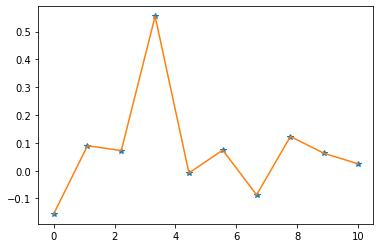

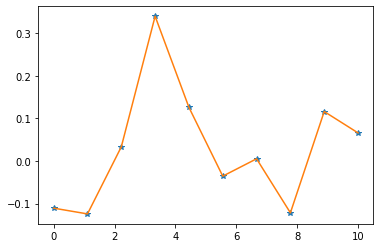

In [0]:
plt.plot(t,y,'*',t,A@x)
plt.show()

Move on to the next notebook on applying Vandermonde interpolation to a beam hardening problem in CT imaging: https://colab.research.google.com/drive/1AMKoOjs7y6l18d70RcbHMLU9ZFxkzRpO
